In [1]:
import math
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
  def __radd__(self,other):
    return self + other
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self,other):
    return self + (-other)
  
  def __rsub__(self,other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self,other):
    return self * other
  
  def __pow__(self, other):
    assert isinstance(other, (int,float)) #denominator can only be either int or float
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad = (other)* (self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self,other):
    return self * other**-1
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
    

    

a = Value(2.9,label='a')
b = Value(3.2, label='b')
c= Value(10.0,label='c')
e= a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(1.0,label='f')
L = f*d;L.label='L'


In [2]:
a= Value(2.0)
b = Value(1.2)
a-b

Value(data=0.8)

In [3]:
a = Value(2.2)
a/2

Value(data=1.1)

Operator Overloading: Python allows you to redefine the behavior of standard operators (+, -, *, etc.) for custom objects by implementing special methods like __add__, __sub__, and __mul__ in your class.

In [4]:
d._prev

{Value(data=10.0), Value(data=9.28)}

In [5]:
d._op

'+'

In [6]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\krish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
from graphviz import Digraph

def trace(root):
    #set of all nodes and edges in a graph
    nodes, edges = set() , set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # For every value in the graph, create a rectangular node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label , n.data, n.grad), shape='record')
        if n._op:
            # If this value is the result of some operation, add an op node
            dot.node(name=uid + n._op, label=n._op)
            # Connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



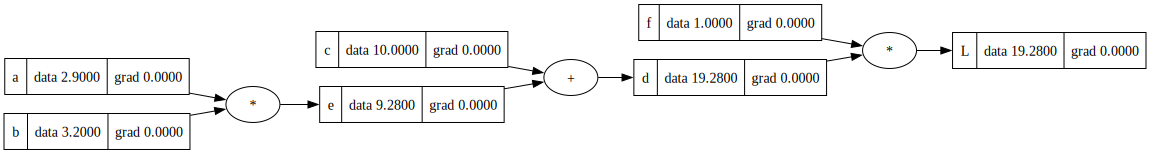

In [8]:
draw_dot(L)

In [9]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w1'
n = x1w1x2w2+b; n.label='n'
o= n.tanh(); o.label='o'
o.backward()

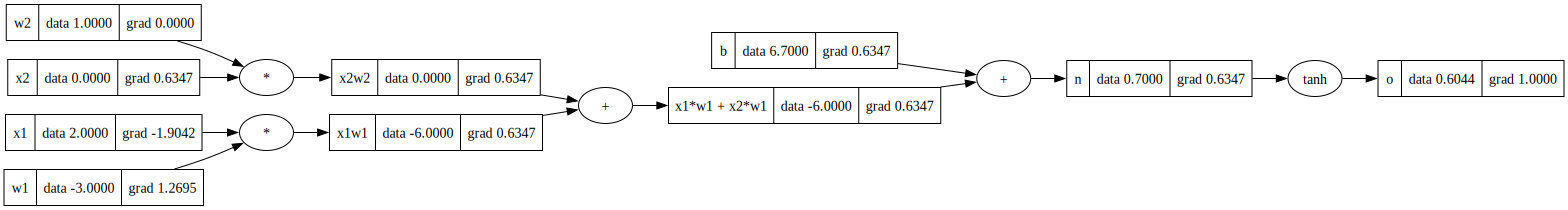

In [10]:

draw_dot(o)

In [5]:
#Doing the same thing but using __exp__

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w1'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o= (e-1)/(e+1)
o.label='o'
o.backward()

In [6]:

draw_dot(o)

NameError: name 'draw_dot' is not defined

In [7]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2),
 Value(data=6.7),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=1.4000000000000004),
 Value(data=4.055199966844676),
 Value(data=-1),
 Value(data=3.0551999668446763),
 Value(data=1),
 Value(data=5.055199966844676),
 Value(data=0.1978161114414182),
 Value(data=0.6043677771171637)]

In [8]:
for node in reversed(topo):
    node._backward()

In [9]:
#We can directly call backward
o.backward()

In [10]:
o.grad = 1.0

In [11]:
o._backward()

In [12]:
n._backward()

In [13]:
x1w1x2w2._backward()

In [14]:
x1w1._backward()
x2w2._backward()

In [15]:
o._backward()

Issue in calculation of gradients due to overwriting when a variable is used more than once

Solution : Accumulating those gradients

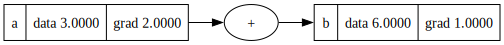

In [22]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

In [7]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

NameError: name 'Value' is not defined

Pytorch implementation

In [49]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached setuptools-75.6.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/203.0 MB 5.6 MB/s eta 0:00:37
   ---------------------------------------- 1.8/203.0 MB 5.6 MB/s eta 0:00:36
    --------------------------------------- 3.4/203.0 MB 6.1 MB/s eta 0:00:33
    --------------------------------------- 4.2/203.0 MB 5.5 MB/s eta 0:00:37
   - -------------------------------------- 5.5/203.0 MB 5.8 MB/s eta 0:00


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\krish\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [37]:
import torch

In [38]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [48]:
import random
class Neuron:

    # nin - no of input connections
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  #random initilaization of weights
        self.b = Value(random.uniform(-1,1)) #Random bias

    #implementing a forward pass of neuron
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    #nin - no of inputs for each neuron
    #nout - no of neurons in a layer
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    #forward pass of a layer
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
        '''
        params = []
        for neuron in self.neurons:
            ps = neurons.parameters()
            params.extend(ps)
        return params
        '''

class MLP:

    #nin - no of input features
    #nouts - list representing no of neurons in each subsequent layer
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    
x = [2.0,3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.819181097545853)

In [49]:
n.parameters()

[Value(data=-0.5309891008921648),
 Value(data=0.1645534968499136),
 Value(data=-0.7560606288514709),
 Value(data=-0.6899432621596875),
 Value(data=-0.14228118449953397),
 Value(data=-0.22642137191003608),
 Value(data=0.666126326272718),
 Value(data=0.6109013644199064),
 Value(data=0.45728734991597864),
 Value(data=-0.5361412577405009),
 Value(data=-0.5015973652403605),
 Value(data=-0.8728857357483961),
 Value(data=-0.9532553671134565),
 Value(data=0.9377112602545541),
 Value(data=-0.6785592201495403),
 Value(data=0.27708557161457503),
 Value(data=0.6859646278457994),
 Value(data=0.8011041337210285),
 Value(data=0.5291686918794019),
 Value(data=0.5582321291510166),
 Value(data=0.5573187385864979),
 Value(data=-0.9636362975452464),
 Value(data=-0.852858201058224),
 Value(data=-0.19540647023020918),
 Value(data=0.8974683263509384),
 Value(data=0.7610820910561924),
 Value(data=-0.5651155690548681),
 Value(data=-0.15160912396883242),
 Value(data=-0.7272685522052278),
 Value(data=0.100541432

In [54]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [51]:
yp = [n(x) for x in xs]
loss=0.0
for ygt,ypred in zip(ys,yp):
    loss = loss + (ypred-ygt)**2 
loss

Value(data=8.017378724179062)

In [43]:
loss.backward()

In [44]:
n.layers[1].neurons[1].w[0].grad

-0.043682418200680084

In [45]:
n.layers[1].neurons[1].w[0].data

-0.6495063816752131

We noticed that this particular neuron of this particular layer is having negative gradient wrt to the loss, which means increasing this will be a good choice to minimize the loss 

In [46]:
for parameter in n.parameters():
    parameter += -0.01 * parameter.grad

TypeError: 'NoneType' object is not iterable

In [ ]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  
  print(k , loss.data)
  

0 0.022072639691101344
1 0.021967809572141075
2 0.02186390857955147
3 0.02176092479431238
4 0.02165884649655738
5 0.021557662161484588
6 0.021457360455367065
7 0.021357930231659834
8 0.021259360527200868
9 0.021161640558503052
10 0.02106475971813566
11 0.020968707571191212
12 0.020873473851837205
13 0.020779048459948594
14 0.02068542145782043
15 0.02059258306695746
16 0.020500523664938732
17 0.020409233782355596
18 0.020318704099820655
19 0.020228925445046106


In [58]:
ypred

[Value(data=0.9505937219460049),
 Value(data=-0.9668359078656146),
 Value(data=-0.9033359729465995),
 Value(data=0.9143019603455314)]